In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import html.parser as htmlParser
import re
from datetime import datetime
from langdetect import detect
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

/Users/vikramjeetsingh/anaconda/envs/python-got3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
np.random.seed(1)

Open data file for Charlottesville event and add some useful columns to the dataframe

In [3]:
# open file
cVille_df = pd.read_json('./Datasets/charlottesville.json')

# add ids
cVille_df['id'] = [url.rsplit('/', 1)[-1] for url in cVille_df['permalink']]

# get number of mentions instead of actual values
cVille_df['mention_count'] = [(len(mentions.split(' ')) if mentions != "" else 0) for mentions in cVille_df['mentions']]

# add hashtag count column as well
cVille_df['hashtag_count'] = [(len(hashtags.split(' ')) if hashtags != "" else 0)  for hashtags in cVille_df['hashtags'] ]

# drop username and geo
cVille_df = cVille_df.drop(['geo', 'username', 'permalink', 'mentions'], axis=1)

# add lang column
cVille_df['lang'] = [detect(text) for text in cVille_df['text']]

# drop non-english rows
cVille_df = cVille_df[cVille_df.lang == 'en']

Open data file for WomenMarch event and add some useful columns to the dataframe

In [4]:
# open file
womenMarch_df = pd.read_json('./Datasets/womenmarch.json')

# add ids
womenMarch_df['id'] = [url.rsplit('/', 1)[-1] for url in womenMarch_df['permalink']]

# get number of mentions instead of actual values
womenMarch_df['mention_count'] = [(len(mentions.split(' ')) if mentions != "" else 0) for mentions in womenMarch_df['mentions']]

# add hashtag count column as well
womenMarch_df['hashtag_count'] = [(len(hashtags.split(' ')) if hashtags != "" else 0)  for hashtags in womenMarch_df['hashtags'] ]

# drop username and geo
womenMarch_df = womenMarch_df.drop(['geo', 'username', 'permalink', 'mentions'], axis=1)

# add lang column
womenMarch_df['lang'] = [detect(text) for text in womenMarch_df['text']]

# drop non-english rows
womenMarch_df = womenMarch_df[womenMarch_df.lang == 'en']

Some more preprocessing of data.

In [5]:
def containsChar(text, pattern):
    for word in text.split(' '):
        if word == pattern: 
            return True
    return False

Preprocess data function

In [6]:
# This method preprocesses the data in given dataframe
# wasViolent = True indicates violent event and False indicates non-violent event 

def preprocessData(df, wasViolent):
    
    # convert html elements to readable format (also convert text to lowercase)
    filteredText = [htmlParser.unescape(text.lower()) for text in df['text']]

    # remove urls (because urls conatain spaces that make it difficult, this will stop at ellipsis or # or @ or end of line)
    # not 100% accurate but decent approach
    url_pattern = re.compile("http(.+?)(@\S+|#\S+|\\u2026|$)")
    filteredText = [re.sub(url_pattern, "", text) for text in filteredText]

    # remove usernames and mentions
    username_pattern = re.compile("@\S+")
    filteredText = [re.sub(username_pattern, "", text) for text in filteredText]

    # remove hashtags
    hashtag_pattern = re.compile("#\S+")
    filteredText = [re.sub(hashtag_pattern, "", text) for text in filteredText]

    # emoticon handling (replace positive_emojis with pos_emoji and negative_emojis with neg_emoji keyword)
    pos_emojis = [':-)', ':)', '(:', '(-:', ':-D', ':D', 'X-D', 'XD', 'xD', '<3', ':*', ';-)', ';)', ';-D', ';D', '(;', '(-;']
    filteredText = [' '.join([('pos_emoji' if word in pos_emojis else word) for word in text.split(' ')]) for text in filteredText]

    # add two new features (pos_emoji and neg_emoji - 1 for presence and 0 for absence)
    df['pos_emoji'] = [(1 if containsChar(text, 'pos_emoji') else 0) for text in filteredText]
    df['neg_emoji'] = [(1 if containsChar(text, 'neg_emoji') else 0) for text in filteredText]
    
    neg_emojis = [":-(", ":(", "):", ")-:", ":,(", ":'(", ':"(', ":(("]
    filteredText = [' '.join([('neg_emoji' if word in neg_emojis else word) for word in text.split(' ')]) for text in filteredText]

    # handle punctuations (add punc_excl=1 if ! exists else 0, same with punc_ques and ?)
    df['punc_excl'] = [(1 if containsChar(text, '!') else 0) for text in filteredText]
    df['punc_ques'] = [(1 if containsChar(text, '?') else 0) for text in filteredText]
    
    # remove pictures
    pic_pattern = re.compile("pic.twitter.com(.+)(/s|$)")
    filteredText = [re.sub(pic_pattern, "", text) for text in filteredText]

    # remove question marks and dollar signs
    removableChars = ['?', '$']
    filteredText = [' '.join([('' if word in removableChars else word) for word in text.split(' ')]) for text in filteredText]

    # remove random words (if still there is : or emoji then ignore them)
    random_pattern = re.compile("(&|:|!|,|;|)", re.I)
    filteredText = [re.sub(random_pattern, "", text) for text in filteredText]

    # handle repeating characters (replace characters repeating more than twice as two characters)
    repeated_pattern = re.compile(r"(.)\1{1,}")
    filteredText = [re.sub(repeated_pattern, r'\1\1', text) for text in filteredText]

    # add label
    df['violent'] = [1 if wasViolent else 0] * df.shape[0]

    # add filteredText column to dataframe
    df['filteredText'] = filteredText
    
    return df[['id', 'date', 'filteredText', 'hashtags', 'favorites', 'retweets', 'mention_count', 'hashtag_count', 'pos_emoji', 'neg_emoji', 'punc_excl', 'punc_ques', 'violent']]

Check number of valid samples in English

In [7]:
print(cVille_df.shape)
print(womenMarch_df.shape)

(153951, 9)
(109951, 9)


Preprocess both Charlottesville and WomenMarch data

In [8]:
cVille_preprocessed_df = preprocessData(cVille_df, wasViolent=True)
womenMarch_preprocessed_df = preprocessData(womenMarch_df, wasViolent=False)

In [9]:
cVille_preprocessed_df.head()

,id,date,filteredText,hashtags,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,violent
0,884925177917845504,2017-07-11,de blasio’s trip was approved for ‘city purpos...,#commies #antifa,0,2,0,2,0,0,0,0,1
1,884924281951576064,2017-07-11,alt-right trump-supporting neo-nazi confirmed.,,0,0,0,0,0,0,0,0,1
2,884923880938328066,2017-07-11,this. kills me. i remember seeing around duri...,#RobertGrodt #Occupy #BijiRojava #antifa,7,4,0,4,0,0,0,0,1
3,884923588960280576,2017-07-11,is resorting to violence and unrest to silenc...,#antifa,0,0,0,1,0,0,0,0,1
4,884922175748059136,2017-07-11,neo-nazi july 12th internet-wide day of act...,#Politics #Collusion #NetNeutrality,0,1,1,3,0,0,0,0,1


In [10]:
womenMarch_preprocessed_df.head()

,id,date,filteredText,hashtags,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,violent
0,921443913398972416,2017-10-20,can we make our message any clearer?,#MeToo #EndRapeCulture #NotOkay #WhyIMarch,0,1,0,4,0,0,0,0,0
1,921204515738546176,2017-10-19,anyone who doesn't support affordable is not ...,#birthcontrol #prolife #ProofIsInThePudding #W...,1,1,0,5,0,0,0,0,0
2,921100053720256514,2017-10-19,each and every day for,#WhyIMarch #RacialJustice #M4RJ #BlackLivesMatter,0,2,0,4,0,0,0,0,0
3,920843500781953024,2017-10-18,because deserve a livable future.,#whyimarch #youth,0,1,1,2,0,0,0,0,0
4,920765197605855232,2017-10-18,started a conversation with my daughter . i ...,#MeToo #WhyIMarch #ShePersisted,2,3,1,3,0,0,0,0,0


In [11]:
# write preprocessed data back to to the disk
cVille_preprocessed_df.to_csv('./Datasets/charlottesville_preprocessed.csv', sep='\t', index=False)
womenMarch_preprocessed_df.to_csv('./Datasets/womenMarch_preprocessed.csv', sep='\t', index=False)

Read Charlottesville and Women March preprocessed data from the disk

In [12]:
cVille_preprocessed_df = pd.read_csv('./Datasets/charlottesville_preprocessed.csv', sep='\t')
womenMarch_preprocessed_df = pd.read_csv('./Datasets/womenMarch_preprocessed.csv', sep='\t')

Handle NaN values. Replace them with empty string in filteredText column

In [13]:
cVille_preprocessed_df.info()
cVille_preprocessed_df['filteredText'].fillna("", inplace=True)
cVille_preprocessed_df['hashtags'].fillna("", inplace=True)
cVille_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153951 entries, 0 to 153950
Data columns (total 13 columns):
id               153951 non-null int64
date             153951 non-null object
filteredText     153889 non-null object
hashtags         143918 non-null object
favorites        153951 non-null int64
retweets         153951 non-null int64
mention_count    153951 non-null int64
hashtag_count    153951 non-null int64
pos_emoji        153951 non-null int64
neg_emoji        153951 non-null int64
punc_excl        153951 non-null int64
punc_ques        153951 non-null int64
violent          153951 non-null int64
dtypes: int64(10), object(3)
memory usage: 15.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153951 entries, 0 to 153950
Data columns (total 13 columns):
id               153951 non-null int64
date             153951 non-null object
filteredText     153951 non-null object
hashtags         153951 non-null object
favorites        153951 non-null int64
retweets         1

In [14]:
womenMarch_preprocessed_df.info()
womenMarch_preprocessed_df['hashtags'].fillna("", inplace=True)
womenMarch_preprocessed_df['filteredText'].fillna("", inplace=True)
womenMarch_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109951 entries, 0 to 109950
Data columns (total 13 columns):
id               109951 non-null int64
date             109951 non-null object
filteredText     109811 non-null object
hashtags         109951 non-null object
favorites        109951 non-null int64
retweets         109951 non-null int64
mention_count    109951 non-null int64
hashtag_count    109951 non-null int64
pos_emoji        109951 non-null int64
neg_emoji        109951 non-null int64
punc_excl        109951 non-null int64
punc_ques        109951 non-null int64
violent          109951 non-null int64
dtypes: int64(10), object(3)
memory usage: 10.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109951 entries, 0 to 109950
Data columns (total 13 columns):
id               109951 non-null int64
date             109951 non-null object
filteredText     109951 non-null object
hashtags         109951 non-null object
favorites        109951 non-null int64
retweets         1

In [15]:
womenMarch_preprocessed_df.head()

,id,date,filteredText,hashtags,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,violent
0,921443913398972416,2017-10-20,can we make our message any clearer?,#MeToo #EndRapeCulture #NotOkay #WhyIMarch,0,1,0,4,0,0,0,0,0
1,921204515738546176,2017-10-19,anyone who doesn't support affordable is not ...,#birthcontrol #prolife #ProofIsInThePudding #W...,1,1,0,5,0,0,0,0,0
2,921100053720256514,2017-10-19,each and every day for,#WhyIMarch #RacialJustice #M4RJ #BlackLivesMatter,0,2,0,4,0,0,0,0,0
3,920843500781953024,2017-10-18,because deserve a livable future.,#whyimarch #youth,0,1,1,2,0,0,0,0,0
4,920765197605855232,2017-10-18,started a conversation with my daughter . i ...,#MeToo #WhyIMarch #ShePersisted,2,3,1,3,0,0,0,0,0


In [16]:
# below is part of preprocessing
def feature_reduced_text(text, stop_words, lemmatizer):
    # tokenization
    tokens = word_tokenize(text)

    # remove stopwords from text
    tokens = [token for token in tokens if token not in stop_words]

    # lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # pos tagging
    pos_tags = nltk.pos_tag(tokens)
    
    # return only relevant words (adjective, verb, adverb, noun with all of their variations)
    return ' '.join([tag[0] for tag in pos_tags if tag[1] in ['JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ']])

In [17]:
stops = set(stopwords.words('english'))
# We will use not for negation (may not be perfect but decent enough)
stops.remove('not')
word_lemmatizer = WordNetLemmatizer()

cVille_preprocessed_df['preprocessedText'] = [feature_reduced_text(text, stop_words=stops, lemmatizer=word_lemmatizer) for text in cVille_preprocessed_df['filteredText'].tolist()]
womenMarch_preprocessed_df['preprocessedText'] = [feature_reduced_text(text, stop_words=stops, lemmatizer=word_lemmatizer) for text in womenMarch_preprocessed_df['filteredText'].tolist()]

Start Data transformation (negation handling, sentiment/polarity score and feature extraction)

In [18]:
# Negation handling (replace (isn't, ain't, haven't etc with not. stop words don't matter anyways))

def getNegationHandledText(text):
    negation_pattern = re.compile(r"(\w*)n't ")
    cleanedText = re.sub(negation_pattern, 'not ', text)
    
    # phrase occuring after not (combine all sub phrases to one phrase)
    negationSplit = cleanedText.split(' not ')
    positivePhrase = negationSplit[0]
    negativePhrase = ' '.join(negationSplit[1:])
                       
    # return words with _NEG appended to them
    if negativePhrase:
        return ' '.join([positivePhrase, ' '.join([word + "_NEG" for word in negativePhrase.split(' ') if word != " "])])
    else:
        return text

In [19]:
# add negation handled text to Charlottesville df
cVille_preprocessed_df['negationText'] = [getNegationHandledText(text) for text in cVille_preprocessed_df['preprocessedText']]

# add negation handled text to Women March df
womenMarch_preprocessed_df['negationText'] = [getNegationHandledText(text) for text in womenMarch_preprocessed_df['preprocessedText']]

In [20]:
# Get sentiment score for hashtag sentences
def hashtag_sentiment_score(hashtags):
    # Convert hashtag to words/sentences
    def hashtagToSentence(hashtag):
        return " ".join([word for word in re.split('([A-Z][a-z]+)', hashtag) if word])
    
    scores = [vaderAnalyzer.polarity_scores(hashtagToSentence(hashtag))['compound'] for hashtag in hashtags]
    return scores

def sentiment_score(tweet, analyzer):
    hashtag_scores = hashtag_sentiment_score(tweet['hashtags'].split())
    text_sentiment_score = analyzer.polarity_scores(tweet['preprocessedText'])['compound']
    
    normalized_score = (np.sum(hashtag_scores) + text_sentiment_score) / (len(hashtag_scores) + 1)
    return normalized_score

Calculate sentiment score/polarity calculation. Here, we use two methods to calculate polarity scores.
1. Vader Sentiment Intensity Analyzer that takes care of negation and is built for messy social media data like Twitter
2. Our approach to negate the polarities of words existing after not (not itself is not considered in this case)

In [21]:
# Part 1 - Calculate Vader score for text
vaderAnalyzer = SentimentIntensityAnalyzer()

cVille_preprocessed_df['vaderTextScore'] = [vaderAnalyzer.polarity_scores(text)['compound'] for text in cVille_preprocessed_df['preprocessedText']]
womenMarch_preprocessed_df['vaderTextScore'] = [vaderAnalyzer.polarity_scores(text)['compound'] for text in womenMarch_preprocessed_df['preprocessedText']]

# Part 2 - Calculate _NEG handled score

# Calculate normalized sentiment score with Vader (both text and hashtags)
cVille_preprocessed_df['vaderScore'] = [sentiment_score(row, vaderAnalyzer) for index, row in cVille_preprocessed_df.iterrows()]
womenMarch_preprocessed_df['vaderScore'] = [sentiment_score(row, vaderAnalyzer) for index, row in womenMarch_preprocessed_df.iterrows()]

In [22]:
cVille_preprocessed_df.drop(['negationText'], axis=1, inplace=True)
womenMarch_preprocessed_df.drop(['negationText'], axis=1, inplace=True)

cVille_preprocessed_df.head()

,id,date,filteredText,hashtags,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,violent,preprocessedText,vaderTextScore,vaderScore
0,884925177917845504,2017-07-11,de blasio’s trip was approved for ‘city purpos...,#commies #antifa,0,2,0,2,0,0,0,0,1,’ trip approved ‘ city purpose ’ bashing trump...,0.4215,0.140500
1,884924281951576064,2017-07-11,alt-right trump-supporting neo-nazi confirmed.,,0,0,0,0,0,0,0,0,1,alt-right trump-supporting neo-nazi confirmed,0.0000,0.000000
2,884923880938328066,2017-07-11,this. kills me. i remember seeing around duri...,#RobertGrodt #Occupy #BijiRojava #antifa,7,4,0,4,0,0,0,0,1,kill remember seeing around rest power comrade,-0.6908,-0.138160
3,884923588960280576,2017-07-11,is resorting to violence and unrest to silenc...,#antifa,0,0,0,1,0,0,0,0,1,resorting violence unrest silence opposition f...,-0.8271,-0.413550
4,884922175748059136,2017-07-11,neo-nazi july 12th internet-wide day of act...,#Politics #Collusion #NetNeutrality,0,1,1,3,0,0,0,0,1,neo-nazi july internet-wide day action save,0.4939,0.123475


In [23]:
womenMarch_preprocessed_df.head()

,id,date,filteredText,hashtags,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,violent,preprocessedText,vaderTextScore,vaderScore
0,921443913398972416,2017-10-20,can we make our message any clearer?,#MeToo #EndRapeCulture #NotOkay #WhyIMarch,0,1,0,4,0,0,0,0,0,make message clearer,0.0000,-0.172060
1,921204515738546176,2017-10-19,anyone who doesn't support affordable is not ...,#birthcontrol #prolife #ProofIsInThePudding #W...,1,1,0,5,0,0,0,0,0,anyone n't support affordable not,-0.3089,-0.051483
2,921100053720256514,2017-10-19,each and every day for,#WhyIMarch #RacialJustice #M4RJ #BlackLivesMatter,0,2,0,4,0,0,0,0,0,day,0.0000,0.110500
3,920843500781953024,2017-10-18,because deserve a livable future.,#whyimarch #youth,0,1,1,2,0,0,0,0,0,deserve livable future,0.0000,0.000000
4,920765197605855232,2017-10-18,started a conversation with my daughter . i ...,#MeToo #WhyIMarch #ShePersisted,2,3,1,3,0,0,0,0,0,started conversation daughter pray never exper...,0.6310,0.157750


In [24]:
def getDays(dateStrings, finalDateStr):
    dateFormat = '%Y-%m-%d'
    
    def dateFromStr(dStr):
        return datetime.strptime(dStr, dateFormat)
    
    finalDate = dateFromStr(finalDateStr)   
    return [(finalDate - dateFromStr(dateStr)).days for dateStr in dateStrings]

Remove entries which are during the events as they dont help in predicting (discuss with the team)

In [25]:
# get days
cVille_preprocessed_df['days_to_event'] = getDays(cVille_preprocessed_df['date'], '2017-08-11')
womenMarch_preprocessed_df['days_to_event'] = getDays(womenMarch_preprocessed_df['date'], '2017-01-21')

# get relevant data
cVille_preprocessed_relevant_df = cVille_preprocessed_df[(cVille_preprocessed_df.days_to_event <= 60) & (cVille_preprocessed_df.days_to_event > 0)]
womenMarch_preprocessed_relevant_df = womenMarch_preprocessed_df[(womenMarch_preprocessed_df.days_to_event <= 60) & (womenMarch_preprocessed_df.days_to_event > 0)]

In [26]:
# import collections
# collections.Counter(womenMarch_preprocessed_relevant_df['date'])

Feature Extraction

1. Tf-idf vectorizer
2. Subset relevant features in a data frame

In [27]:
cVille_features_df = cVille_preprocessed_relevant_df[['id', 'date', 'days_to_event', 'preprocessedText', 'favorites', 'retweets', 'mention_count', 'hashtag_count', 'pos_emoji', 'neg_emoji', 'punc_excl', 'punc_ques', 'vaderTextScore', 'vaderScore', 'violent']]
womenMarch_features_df = womenMarch_preprocessed_relevant_df[['id', 'date', 'days_to_event', 'preprocessedText', 'favorites', 'retweets', 'mention_count', 'hashtag_count', 'pos_emoji', 'neg_emoji', 'punc_excl', 'punc_ques', 'vaderTextScore', 'vaderScore', 'violent']]

cVille_features_df.info()
womenMarch_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30614 entries, 0 to 153950
Data columns (total 15 columns):
id                  30614 non-null int64
date                30614 non-null object
days_to_event       30614 non-null int64
preprocessedText    30614 non-null object
favorites           30614 non-null int64
retweets            30614 non-null int64
mention_count       30614 non-null int64
hashtag_count       30614 non-null int64
pos_emoji           30614 non-null int64
neg_emoji           30614 non-null int64
punc_excl           30614 non-null int64
punc_ques           30614 non-null int64
vaderTextScore      30614 non-null float64
vaderScore          30614 non-null float64
violent             30614 non-null int64
dtypes: float64(2), int64(11), object(2)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29747 entries, 40101 to 109950
Data columns (total 15 columns):
id                  29747 non-null int64
date                29747 non-null object
days_to_e

In [28]:
training_features_df = pd.concat([cVille_features_df, womenMarch_features_df])
training_features_df.head()

,id,date,days_to_event,preprocessedText,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,vaderTextScore,vaderScore,violent
0,884925177917845504,2017-07-11,31,’ trip approved ‘ city purpose ’ bashing trump...,0,2,0,2,0,0,0,0,0.4215,0.140500,1
1,884924281951576064,2017-07-11,31,alt-right trump-supporting neo-nazi confirmed,0,0,0,0,0,0,0,0,0.0000,0.000000,1
2,884923880938328066,2017-07-11,31,kill remember seeing around rest power comrade,7,4,0,4,0,0,0,0,-0.6908,-0.138160,1
3,884923588960280576,2017-07-11,31,resorting violence unrest silence opposition f...,0,0,0,1,0,0,0,0,-0.8271,-0.413550,1
4,884922175748059136,2017-07-11,31,neo-nazi july internet-wide day action save,0,1,1,3,0,0,0,0,0.4939,0.123475,1


In [29]:
training_features_df.shape

(60361, 15)

In [30]:
# use tf-idf vectorizer
tv = TfidfVectorizer(stop_words='english', min_df=0.0005)
tfidf_features = tv.fit_transform(training_features_df['preprocessedText'])

In [31]:
tfidf_features.shape

(60361, 1856)

In [32]:
# tv.vocabulary_

In [33]:
# create pandas dataframe from tfidf features
tfidf_features_df = pd.DataFrame(tfidf_features.toarray())

In [34]:
# reset indices so that they can be concatenated into one dataframe
temp_training_features_df = training_features_df.reset_index(drop=True)
temp_tfidf_features_df = tfidf_features_df.reset_index(drop=True)

final_training_features_df = pd.concat([temp_training_features_df, temp_tfidf_features_df], axis=1)

In [35]:
final_training_features_df.shape

(60361, 1871)

In [36]:
final_training_features_df.head()

,id,date,days_to_event,preprocessedText,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,...,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855
0,884925177917845504,2017-07-11,31,’ trip approved ‘ city purpose ’ bashing trump...,0,2,0,2,0,0,...,0.0,0.0,0.0,0.449902,0.0,0.0,0.0,0.0,0.0,0.0
1,884924281951576064,2017-07-11,31,alt-right trump-supporting neo-nazi confirmed,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,884923880938328066,2017-07-11,31,kill remember seeing around rest power comrade,7,4,0,4,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,884923588960280576,2017-07-11,31,resorting violence unrest silence opposition f...,0,0,0,1,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,884922175748059136,2017-07-11,31,neo-nazi july internet-wide day action save,0,1,1,3,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# drop id, date and preprocessedText from final training set
final_training_features_df.drop(['id', 'date', 'preprocessedText'], axis=1, inplace=True)

In [38]:
final_training_features_df.head()

,days_to_event,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,vaderTextScore,...,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855
0,31,0,2,0,2,0,0,0,0,0.4215,...,0.0,0.0,0.0,0.449902,0.0,0.0,0.0,0.0,0.0,0.0
1,31,0,0,0,0,0,0,0,0,0.0000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,31,7,4,0,4,0,0,0,0,-0.6908,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,31,0,0,0,1,0,0,0,0,-0.8271,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,31,0,1,1,3,0,0,0,0,0.4939,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
final_training_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60361 entries, 0 to 60360
Columns: 1868 entries, days_to_event to 1855
dtypes: float64(1858), int64(10)
memory usage: 860.2 MB


Data Exploration and Visualization

In [40]:
final_training_features_df.describe()

,days_to_event,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,vaderTextScore,...,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855
count,60361.000000,60361.000000,60361.000000,60361.000000,60361.000000,60361.000000,60361.0,60361.000000,60361.000000,60361.000000,...,60361.000000,60361.000000,60361.000000,60361.000000,60361.000000,60361.000000,60361.000000,60361.000000,60361.000000,60361.000000
mean,20.636205,17.853399,8.528122,0.387171,2.132022,0.002286,0.0,0.018770,0.014397,0.014516,...,0.002827,0.000693,0.000310,0.000396,0.002772,0.000806,0.000367,0.000730,0.000250,0.000306
std,19.349337,270.079900,116.582746,0.829539,1.780960,0.047760,0.0,0.135714,0.119120,0.420913,...,0.042969,0.018539,0.012763,0.014786,0.036740,0.020916,0.014423,0.018073,0.011311,0.011897
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.980500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,-0.205700,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,5.000000,2.000000,1.000000,3.000000,0.000000,0.0,0.000000,0.000000,0.318200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,60.000000,25679.000000,9456.000000,14.000000,24.000000,1.000000,0.0,1.000000,1.000000,0.997200,...,1.000000,0.774780,0.730131,0.952871,0.735573,1.000000,1.000000,1.000000,0.864690,0.696542


In [41]:
final_training_features_df.groupby(['days_to_event', 'violent'])['vaderScore'].mean()

days_to_event  violent
1              0          0.049732
               1         -0.025860
2              0          0.046631
               1         -0.044140
3              0          0.053238
               1         -0.037953
4              0          0.053761
               1         -0.042487
5              0          0.058585
               1         -0.039009
6              0          0.052644
               1         -0.070629
7              0          0.051603
               1         -0.042247
8              0          0.044554
               1         -0.035829
9              0          0.038212
               1         -0.039363
10             0          0.057710
               1         -0.050866
11             0          0.035761
               1         -0.072898
12             0          0.070436
               1         -0.053681
13             0          0.079391
               1         -0.069671
14             0          0.036559
               1         -0.0685

Checking the pattern of Vader Sentiment Score (Text + Hashtags) in 60 days before both the events

In [42]:
# get subset dataframe with days_to_event, vaderScore and violent label
vader_df = final_training_features_df[['days_to_event', 'vaderScore', 'violent']].sort_values(by='days_to_event')

In [43]:
# split into violent and non-violent sub-dataframe
vader_df_vio = vader_df[vader_df.violent == 1]
vader_df_non = vader_df[vader_df.violent == 0]

In [44]:
def handleMissingDays(series):
    series[52] = 0.0
    series[56] = 0.0
    series[58] = 0.0
    return series.sort_index()

In [45]:
# violent mean
vio_mean = vader_df_vio.groupby('days_to_event')['vaderScore'].mean()

# non-violent mean
non_mean = vader_df_non.groupby('days_to_event')['vaderScore'].mean()
non_mean = handleMissingDays(non_mean)

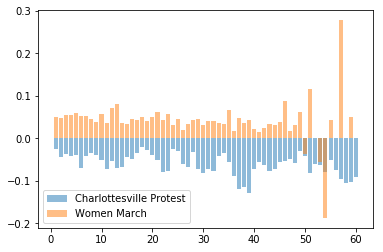

In [46]:
# draw plot
plt.bar(range(1,61), vio_mean, alpha=0.5, label='Charlottesville Protest')
plt.bar(range(1,61), non_mean, alpha=0.5, label='Women March')
plt.legend(loc='lower left')
plt.show()

We can see that Charlotessvile protest tweets were negative (on average) and Women March tweets were positive (on average) for 60 days before the events.

In [47]:
# calculate correlation between vaderScore and vaderTextScore
setiment_corr = final_training_features_df['vaderScore'].corr(final_training_features_df['vaderTextScore'])
print(setiment_corr)

# calculate correlation between vaderScore and presence of exclamation marks
excl_corr = final_training_features_df['vaderScore'].corr(final_training_features_df['punc_excl'])
print(excl_corr)

# calculate correlation between vaderScore and presence of question marks
ques_corr = final_training_features_df['vaderScore'].corr(final_training_features_df['punc_ques'])
print(ques_corr)

0.862914180935
0.0278343104361
0.0030695820478


As expected, Sentiment Score for tweet and hashtags is highly correlated with Sentiment Score of tweet text alone.
However, there is no real correlation between sentiment score and presence of exclamation marks or question marks.

In [48]:
final_training_features_df.groupby('pos_emoji')['pos_emoji'].count()

pos_emoji
0    60223
1      138
Name: pos_emoji, dtype: int64

In [49]:
final_training_features_df.groupby('neg_emoji')['neg_emoji'].count()

neg_emoji
0    60361
Name: neg_emoji, dtype: int64

pos_emoji and neg_emoji do not give any valuable information so we will not use it for our final models.

In [50]:
exploratory_df = final_training_features_df[['days_to_event', 'favorites', 'mention_count', 'retweets', 'hashtag_count', 'violent']].sort_values(by='days_to_event')

In [51]:
exploratory_df_vio = exploratory_df[exploratory_df.violent == 1]
exploratory_df_non = exploratory_df[exploratory_df.violent == 0]

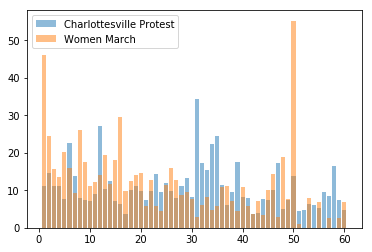

In [52]:
fav_vio_mean = exploratory_df_vio.groupby('days_to_event')['favorites'].mean()
fav_non_mean = exploratory_df_non.groupby('days_to_event')['favorites'].mean()
fav_non_mean = handleMissingDays(fav_non_mean)

plt.bar(range(1,61), fav_vio_mean, alpha=0.5, label='Charlottesville Protest')
plt.bar(range(1,61), fav_non_mean, alpha=0.5, label='Women March')
plt.legend(loc='upper left')
plt.show()

Clearly, non-violent Women March tweets were favorited more on average as compared to Charlottesville tweets

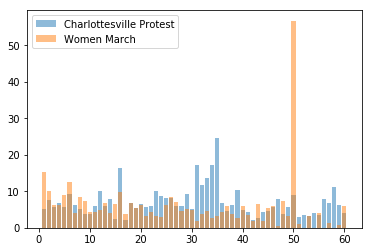

In [53]:
retweet_vio_mean = exploratory_df_vio.groupby('days_to_event')['retweets'].mean()
retweet_non_mean = exploratory_df_non.groupby('days_to_event')['retweets'].mean()
retweet_non_mean = handleMissingDays(retweet_non_mean)

plt.bar(range(1,61), retweet_vio_mean, alpha=0.5, label='Charlottesville Protest')
plt.bar(range(1,61), retweet_non_mean, alpha=0.5, label='Women March')
plt.legend(loc='upper left')
plt.show()

Both Charlottesville and Women March tweets were retweeted at a similar rate.

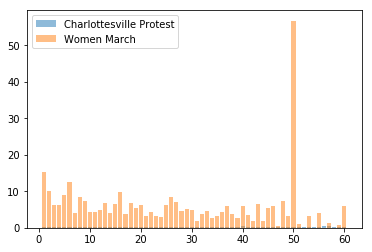

In [54]:
mention_vio_mean = exploratory_df_vio.groupby('days_to_event')['mention_count'].mean()
mention_non_mean = exploratory_df_non.groupby('days_to_event')['mention_count'].mean()
mention_non_mean = handleMissingDays(retweet_non_mean)

plt.bar(range(1,61), mention_vio_mean, alpha=0.5, label='Charlottesville Protest')
plt.bar(range(1,61), mention_non_mean, alpha=0.5, label='Women March')
plt.legend(loc='upper left')
plt.show()

There were hardly any mentions for Charlotteville protest tweets. However, on average mention count for Women March event tweets was on an upward trend leading upto the event.

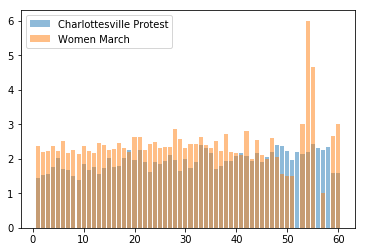

In [55]:
hashtag_vio_mean = exploratory_df_vio.groupby('days_to_event')['hashtag_count'].mean()
hashtag_non_mean = exploratory_df_non.groupby('days_to_event')['hashtag_count'].mean()
hashtag_non_mean = handleMissingDays(hashtag_non_mean)

plt.bar(range(1,61), hashtag_vio_mean, alpha=0.5, label='Charlottesville Protest')
plt.bar(range(1,61), hashtag_non_mean, alpha=0.5, label='Women March')
plt.legend(loc='upper left')
plt.show()

Hashtag count does not seem very interesting for analysis.

Another interesting thing is that Women March tweets got a lot of attention (mentions, retweets, favorites) on the 5oth day before the event for some reason.

Split Train data and Test data 

In [56]:
# shuffle dataset
final_training_features = final_training_features_df.drop(['pos_emoji', 'neg_emoji'], axis=1)
final_training_features_df = final_training_features_df.sample(frac=1, random_state=np.random.seed(1))
final_training_features_df.head()

,days_to_event,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,vaderTextScore,...,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855
7235,42,0,1,0,3,0,0,0,0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16529,59,0,1,0,2,0,0,0,0,-0.7430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58370,15,9,5,2,2,0,0,0,0,-0.5574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7130,42,0,0,0,1,0,0,0,0,-0.7430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48717,1,2,1,1,2,0,0,0,0,0.2960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
final_training_features_df.tail()

,days_to_event,favorites,retweets,mention_count,hashtag_count,pos_emoji,neg_emoji,punc_excl,punc_ques,vaderTextScore,...,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855
50057,2,1,1,0,8,0,0,0,0,0.8555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32511,1,1,0,1,2,0,0,0,0,0.2960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5192,38,2,1,0,2,0,0,0,0,-0.5423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12172,54,1,0,0,0,0,0,0,0,-0.0485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33003,1,5,1,1,3,0,0,0,0,0.1058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Final processed data

In [58]:
final_training_features_df.to_csv('./Datasets/social_unrest_processed.csv', sep='\t', index=False)

In [59]:
Y = final_training_features_df['violent'] 
X = final_training_features_df.loc[:, final_training_features_df.columns != 'violent']

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60361 entries, 7235 to 33003
Columns: 1867 entries, days_to_event to 1855
dtypes: float64(1858), int64(9)
memory usage: 860.2 MB


In [61]:
Y.head()

7235     1
16529    1
58370    0
7130     1
48717    0
Name: violent, dtype: int64

Train test split

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.seed(1))

In [63]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(48288, 1867)
(48288,)
(12073, 1867)
(12073,)


Testing with imbalanced data

Calculate baseline

In [64]:
print(np.mean(Y_train))

0.507931577203


seems like around 50.7% accuracy could be achieved by simply choosing majority class (not violent).

Logistic Regression

In [65]:
logistic_clf = LogisticRegression()
logistic_score = cross_val_score(logistic_clf, X_train, Y_train, scoring='accuracy', cv=5)
print(np.mean(logistic_score))

0.923272986661


Our model is better than baseline as it is above 92% accurate.

Naive Bayes' Model/Classifier

In [66]:
nb_clf = BernoulliNB()
nb_score = cross_val_score(nb_clf, X_train, Y_train, scoring='accuracy', cv=5)
print(np.mean(nb_score))

0.872100666763


Our model is better than baseline as it gives around 87% accuracy.

SVM Classifier

In [67]:
# svm_clf = SVC()
# svm_score = cross_val_score(svm_clf, X_train, Y_train, scoring='accuracy', cv=5)
# print(np.mean(svm_score))

Neural Network Classifier

In [68]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier()
nn_score = cross_val_score(nn_clf, X_train, Y_train, scoring='accuracy', cv=5)
print(np.mean(nn_score))

0.932944180598


Our model is clearly better than baseline as it gives around 93% accuracy without tuning hyperparameters.

Final Accuracy Test

In [69]:
def evaluate(classifier, xTrain, yTrain, xTest, yTest):
    classifier.fit(xTrain, yTrain)
    yPred = classifier.predict(xTest)
    accuracy = accuracy_score(yTest, yPred)
    confusionMat = confusion_matrix(yTest, yPred)
    f1 = f1_score(yTest, yPred)
    return (accuracy, confusionMat, f1)

Accuracy prediction on test data

In [70]:
final_logistic_clf = LogisticRegression()
final_nb_clf = BernoulliNB()
final_nn_clf = MLPClassifier()

logistic_evaluation = evaluate(final_logistic_clf, X_train, Y_train, X_test, Y_test)
nb_evaluation = evaluate(final_nb_clf, X_train, Y_train, X_test, Y_test)
nn_evaluation = evaluate(final_nn_clf, X_train, Y_train, X_test, Y_test)

Logistic Regression Accuracy:
0.9303404290565725

Logistic Regression F1 Score:
 0.929864064715
Logistic Regression Confusion Matrix:
[[5657  329]
 [ 512 5575]]



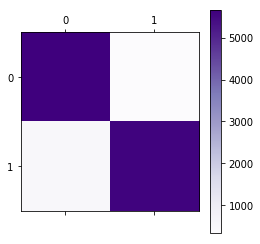

In [71]:
# Logistic regression accuracy
print("Logistic Regression Accuracy:\n{}\n".format(logistic_evaluation[0]))
print("Logistic Regression F1 Score:\n",logistic_evaluation[2])

print("Logistic Regression Confusion Matrix:\n{}\n".format(logistic_evaluation[1]))
plt.matshow(logistic_evaluation[1], cmap='Purples')
plt.colorbar()
plt.show()

Logistic Regression Model gives 93% accuracy with f1 score of 0.929

Neural Network Accuracy:
0.9388718628344239

Neural Network F1 score:
 0.938957816377
Neural Network Confusion Matrix:
[[5659  327]
 [ 411 5676]]



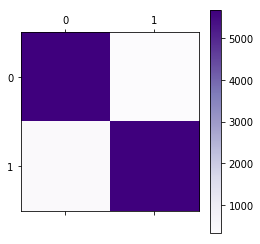

In [72]:
# Neural Network accuracy
print("Neural Network Accuracy:\n{}\n".format(nn_evaluation[0]))
print("Neural Network F1 score:\n",nn_evaluation[2])

print("Neural Network Confusion Matrix:\n{}\n".format(nn_evaluation[1]))
plt.matshow(nn_evaluation[1], cmap='Purples')
plt.colorbar()
plt.show()

Neural Network gives 93.8% accuracy with f1 score of 0.938

Naive Bayes' Accuracy:
0.8714486871531517

Naive Bayes' F1 Score: 0.862970157161
Naive Bayes' Confusion Matrix:
[[5634  352]
 [1200 4887]]



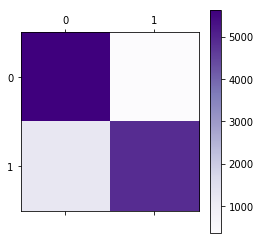

In [73]:
# Naive Bayes' accuracy
print("Naive Bayes' Accuracy:\n{}\n".format(nb_evaluation[0]))
print("Naive Bayes' F1 Score:",nb_evaluation[2])

print("Naive Bayes' Confusion Matrix:\n{}\n".format(nb_evaluation[1]))
plt.matshow(nb_evaluation[1], cmap='Purples')
plt.colorbar()
plt.show()

Naive Bayes' Model gives around 87% accuracy with f1 score of 0.862